## Import CNN/Daily Mail Dataset

In [5]:
from datasets import load_dataset
from utils.sample import sample, print_sample
import torch
import os
import random
import numpy as np
from transformers import set_seed

# Seed for reproducability
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

corpus = load_dataset("cnn_dailymail", "3.0.0")
train_corpus = corpus["train"]
test_corpus = corpus["test"]

example = sample(train_corpus)
print_sample(example, max_chars=200)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jackeinbinder/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Article:
"By . Daily Mail Reporter . PUBLISHED: . 04:57 EST, 9 November 2013 . | . UPDATED: . 05:01 EST, 9 November 2013 . Housebuilders will no longer be allowed to delay big developments after the government...

Highlights:
"'Land-banking' culture to be scrapped to encourage house-building .\nFirms have been exploiting loophole in order to wait for house price rises .\nNew rule comes weeks after Labour's criticised 'land...

Id:
"ebf444be0aa072f39286ae9f709583dd84d85067"



## Compare BART and PEGASUS models

### Select Samples

In [6]:
# Select 100 articles
NUM_SAMPLES = 100
articles = sample(test_corpus, NUM_SAMPLES)

### Import Models

In [7]:
from utils.pipeline import make_bart_pipeline, make_pegasus_pipeline

bart = make_bart_pipeline()
pegasus = make_pegasus_pipeline()

Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


### Prepare Summarizers

In [8]:
from core.summarizer import Summarizer

model_configs = {
    'bart': Summarizer(bart),
    'pegasus': Summarizer(pegasus)
}

### Generate & Evaluate Summaries

Evaluating: BART...

Generating summaries for 100 articles...

Completed in 00:11:17.70


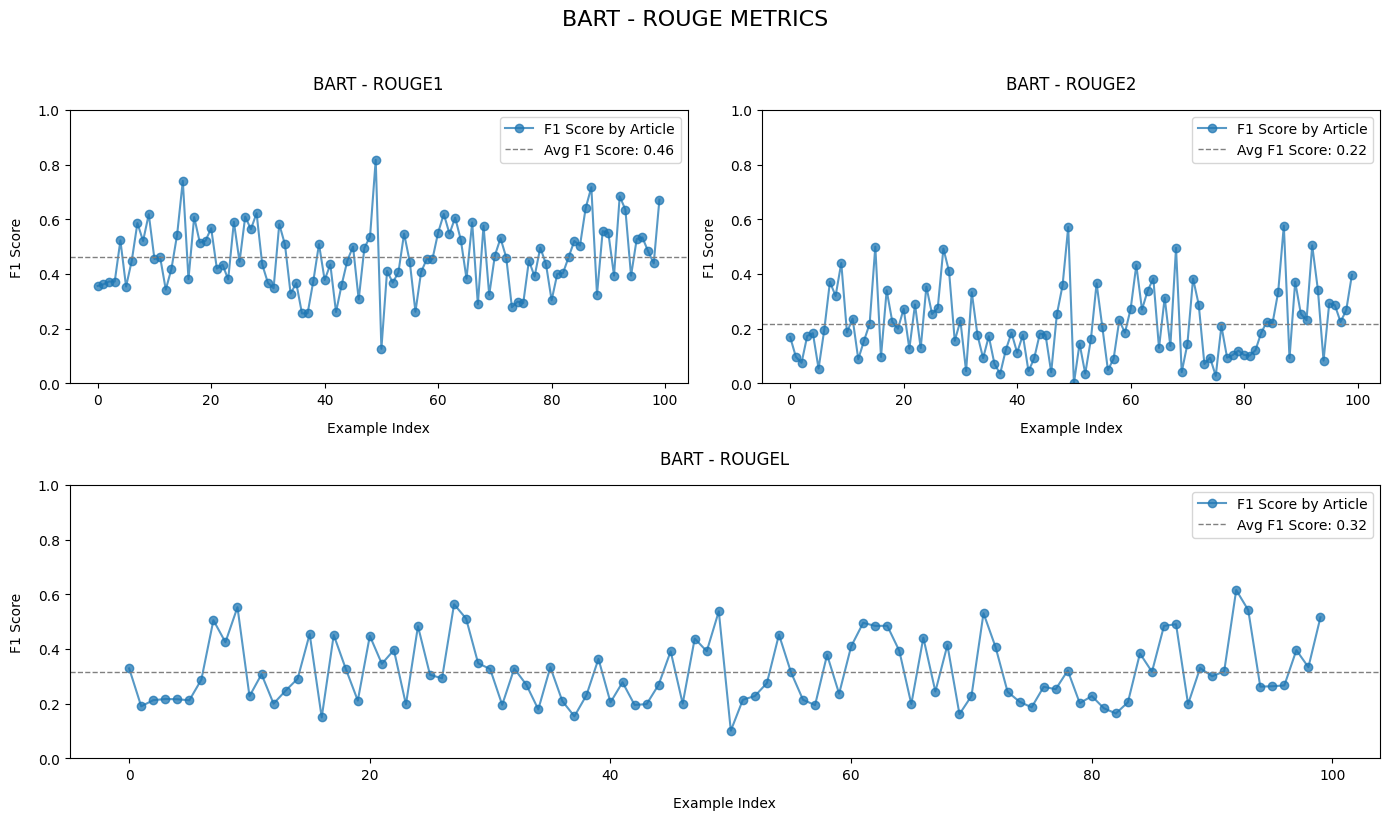

Evaluating: PEGASUS...

Generating summaries for 100 articles...

Completed in 00:16:33.28


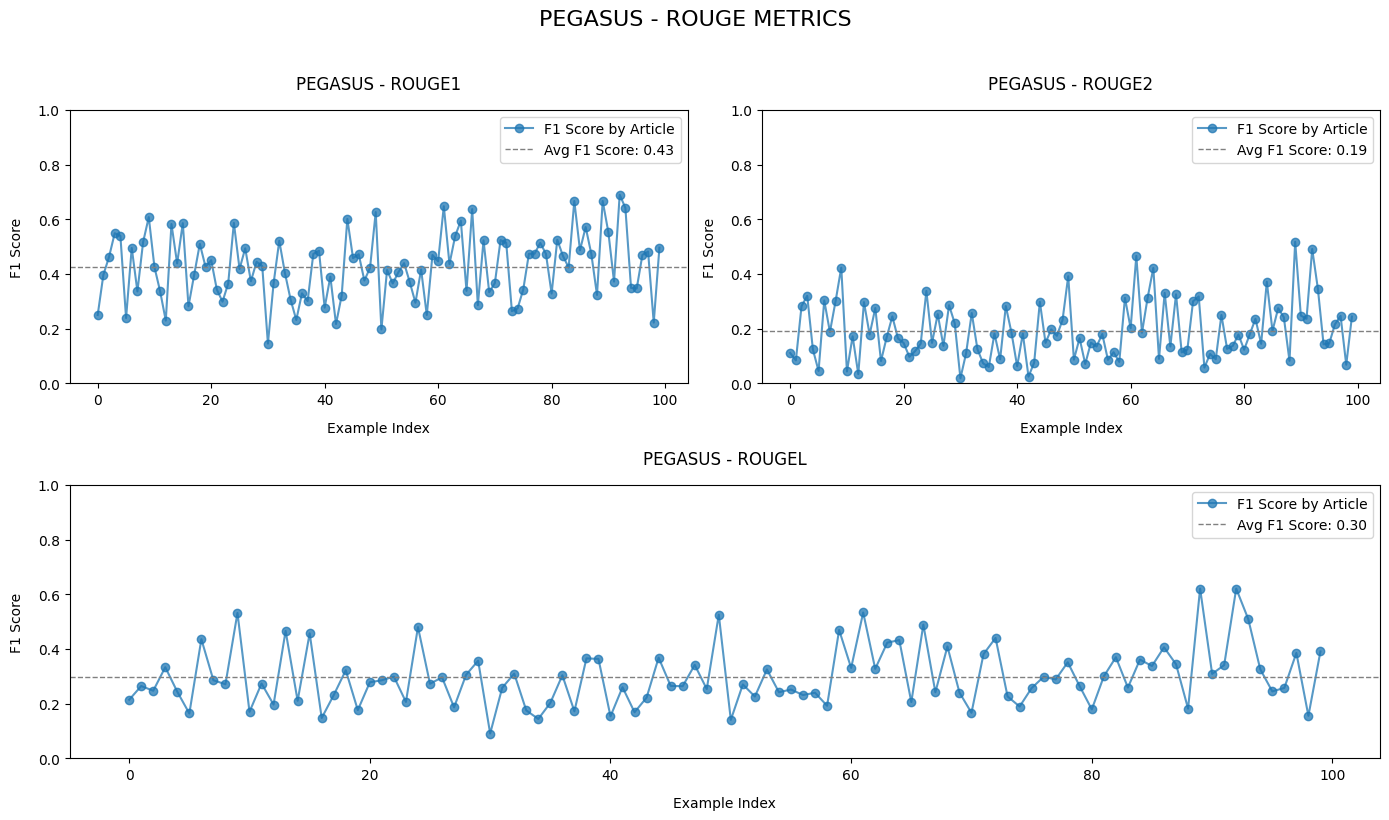

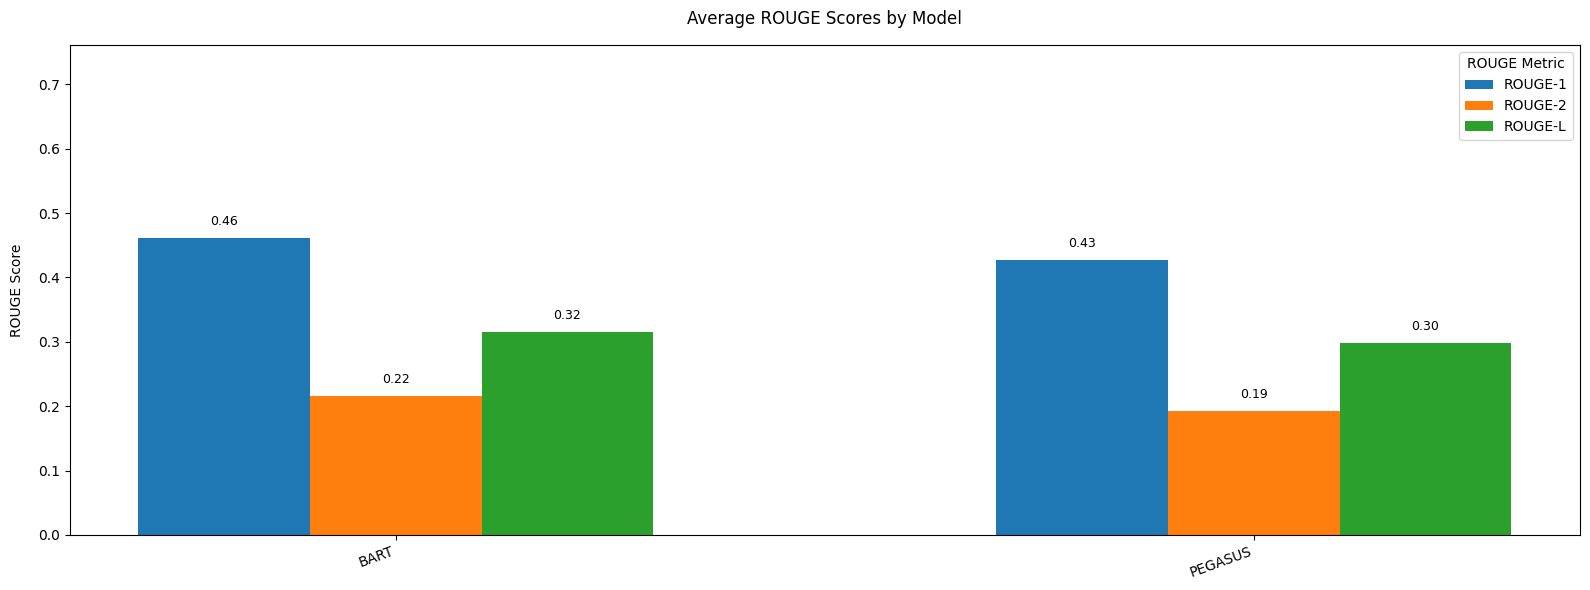

In [9]:
from utils.sum_eval import sum_eval
from utils.plot import plot_avg_rouge, plot_avg_manual_score
import pandas as pd

results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)

model_scores = sum_eval(articles, model_configs)
df_models = pd.DataFrame(model_scores).T.sort_values(by='rougeL', ascending=False)

plot_avg_rouge(model_scores, save_path=os.path.join(results_dir, 'avg_rouge_scores'))

### Extrinsic Evaluation

In [10]:
# Select 10 articles
NUM_RANDOM_SAMPLES = 10
manual_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

In [11]:
# Generate summaries
bart_summarizer = model_configs['bart']
bart_summaries = bart_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:11.28


##### BART

In [12]:
from evaluation.extrinsic_evaluator import ExtrinsicEvaluator

# Evaluate Bart
bart_evaluator = ExtrinsicEvaluator(bart_summaries)
bart_evaluator.evaluate('BART')
bart_id_to_score = {
    "432642e19523c71e986985b0a1bb82f6baa9dc4f": 5,
    "15fffd5f6e0249a50b8ff64afa785a56e3cd6329": 5,
    "a4f3403c0c05589f939d0f4ddb138e8e2c5d288e": 5,
    "bc526b7c50b3b816751a6a692cdb7324d980a576": 5,
    "ca5cf6768d5700c8e944d7ec773d2116075d9003": 5,
    "41722a8d14392fd2999bafbcec86f04d5634590f": 5,
    "85afff41a6d8d564588c54c6b5b9ff972dfe0eff": 5,
    "868be1a9da96d8ddbc357599943293a7684eb271": 5,
    "197354baef143a117e28c3d7e6497fe3f08c975f": 5,
    "f9b726faba76c1808f033491ef21960438ce5914": 5,
}
bart_evaluator.submit_scores(bart_id_to_score)


Manually evaluating BART...
ID: 79b8d3a8ab733f3800885a5819ac9343ac4d1565
Article:
An 18-year-old man has been arrested on suspicion of stabbing his friend's nine-year-old brother to death in a Northern California town. Jordan was stabbed in the neck and declared dead after his family drove him to Brentwood's John Muir Hospital. Deputies put out an alert for Schultz after they said he got away in a truck outside the home. William Schultz (left) was arrested Sunday afternoon, hours after Jordan Almgren (right) was stabbed to death in his home in Discovery Bay . Schultz was arrested at a hospital in Antioch at 3pm. Contra Costa County sheriff's spokesman Jimmy Lee said a nurse who saw media coverage of the case recognized the wanted suspect. Officials didn't say what Schultz was being treated for and the motive for the stabbing remains under investigation. The day before the stabbing, deputies had also been called to the home (right) on Saturday on a request for a psychological evaluation

##### PEGASUS

In [13]:
# Generate Summaries
pegasus_summarizer = model_configs['pegasus']
pegasus_summaries = pegasus_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:49.73


In [14]:
# Evaluate PEGASUS
pegasus_evaluator = ExtrinsicEvaluator(pegasus_summaries)
pegasus_evaluator.evaluate('PEGASUS')
pegasus_id_to_score = {
    "432642e19523c71e986985b0a1bb82f6baa9dc4f": 5,
    "15fffd5f6e0249a50b8ff64afa785a56e3cd6329": 5,
    "a4f3403c0c05589f939d0f4ddb138e8e2c5d288e": 5,
    "bc526b7c50b3b816751a6a692cdb7324d980a576": 5,
    "ca5cf6768d5700c8e944d7ec773d2116075d9003": 5,
    "41722a8d14392fd2999bafbcec86f04d5634590f": 5,
    "85afff41a6d8d564588c54c6b5b9ff972dfe0eff": 5,
    "868be1a9da96d8ddbc357599943293a7684eb271": 5,
    "197354baef143a117e28c3d7e6497fe3f08c975f": 5,
    "f9b726faba76c1808f033491ef21960438ce5914": 5,
}
pegasus_evaluator.submit_scores(pegasus_id_to_score)

Manually evaluating PEGASUS...
ID: 79b8d3a8ab733f3800885a5819ac9343ac4d1565
Article:
An 18-year-old man has been arrested on suspicion of stabbing his friend's nine-year-old brother to death in a Northern California town. Jordan was stabbed in the neck and declared dead after his family drove him to Brentwood's John Muir Hospital. Deputies put out an alert for Schultz after they said he got away in a truck outside the home. William Schultz (left) was arrested Sunday afternoon, hours after Jordan Almgren (right) was stabbed to death in his home in Discovery Bay . Schultz was arrested at a hospital in Antioch at 3pm. Contra Costa County sheriff's spokesman Jimmy Lee said a nurse who saw media coverage of the case recognized the wanted suspect. Officials didn't say what Schultz was being treated for and the motive for the stabbing remains under investigation. The day before the stabbing, deputies had also been called to the home (right) on Saturday on a request for a psychological evaluat

#### Plot Manual Scores

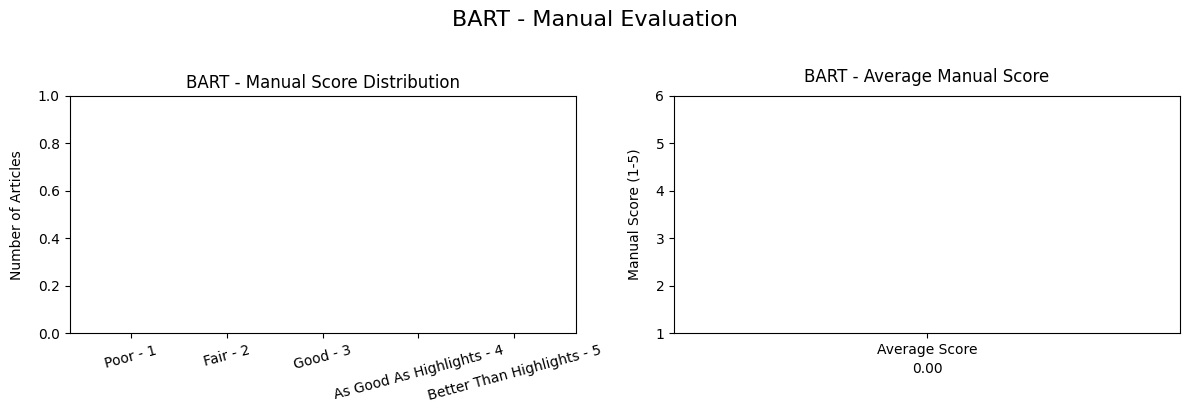

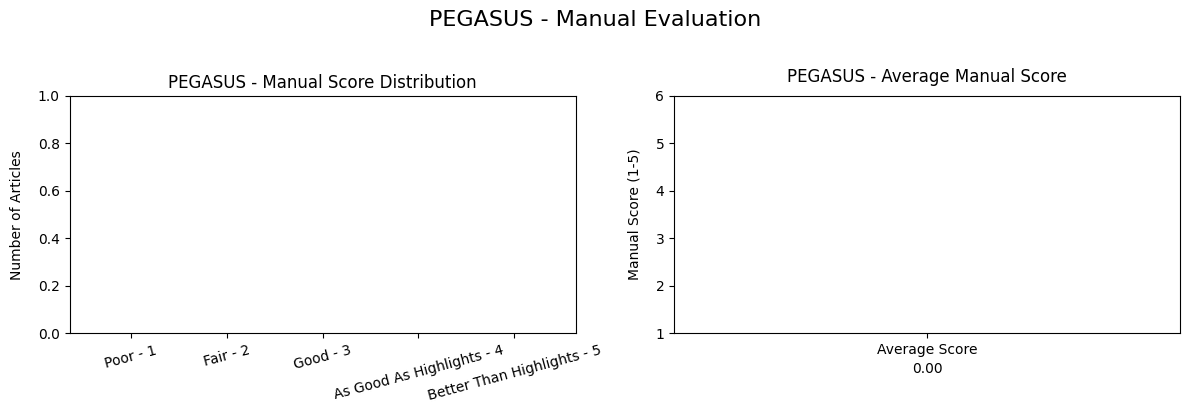

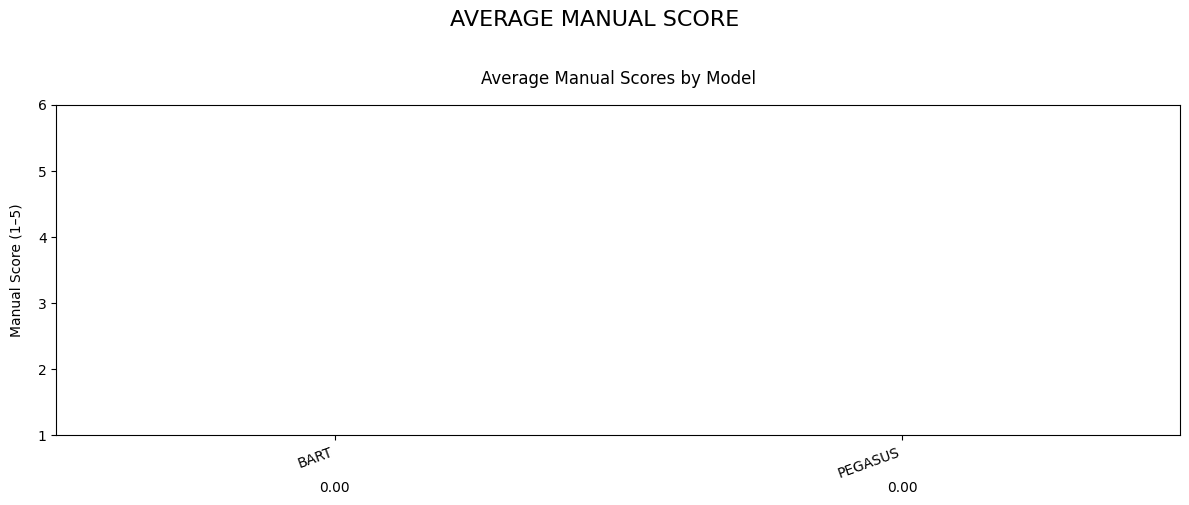

In [15]:
bart_evaluator.plot('BART', save_path=os.path.join(results_dir, 'bart'))
pegasus_evaluator.plot('PEGASUS', save_path=os.path.join(results_dir, 'pegasus'))

avg_manual_scores = {
    'bart': bart_evaluator.avg_score,
    'pegasus': pegasus_evaluator.avg_score
}

plot_avg_manual_score(avg_manual_scores, save_path=os.path.join(results_dir, 'avg_manual_scores'))

#### Winner is BART

## Ablation Study

### Hyperparameter Strategies

In [ ]:
from utils.pipeline import make_bart_pipeline

DEFAULT_MIN_LENGTH = 30
DEFAULT_MAX_LENGTH = 100

bart_pipeline = make_bart_pipeline()  # plain, no generation args

ablation_configs = {
    'bart_default': Summarizer(
        bart_pipeline,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_beam_light': Summarizer(
        bart_pipeline,
        num_beams=4,
        early_stopping=True,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_beam': Summarizer(
        bart_pipeline,
        num_beams=8,
        early_stopping=True,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_short': Summarizer(
        bart_pipeline,
        min_length=20,  # shorter min-length
        max_length=60  # shorter max-length
    ),
    'bart_sample_basic': Summarizer(
        bart_pipeline,
        do_sample=True,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_sample_temp': Summarizer(
        bart_pipeline,
        do_sample=True,
        temperature=0.7,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_sample_topk': Summarizer(
        bart_pipeline,
        do_sample=True,
        top_k=50,
        temperature=0.8,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_sample_topp': Summarizer(
        bart_pipeline,
        do_sample=True,
        top_p=0.92,
        temperature=0.8,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
    'bart_sample_topkp': Summarizer(
        bart_pipeline,
        do_sample=True,
        top_k=50,
        top_p=0.92,
        temperature=0.8,
        min_length= DEFAULT_MIN_LENGTH,
        max_length= DEFAULT_MAX_LENGTH
    ),
}

### Prepare Summarizers

### Generate & Evaluate Summaries

Evaluating: BART_DEFAULT...

Generating summaries for 100 articles...

Completed in 00:11:8.67


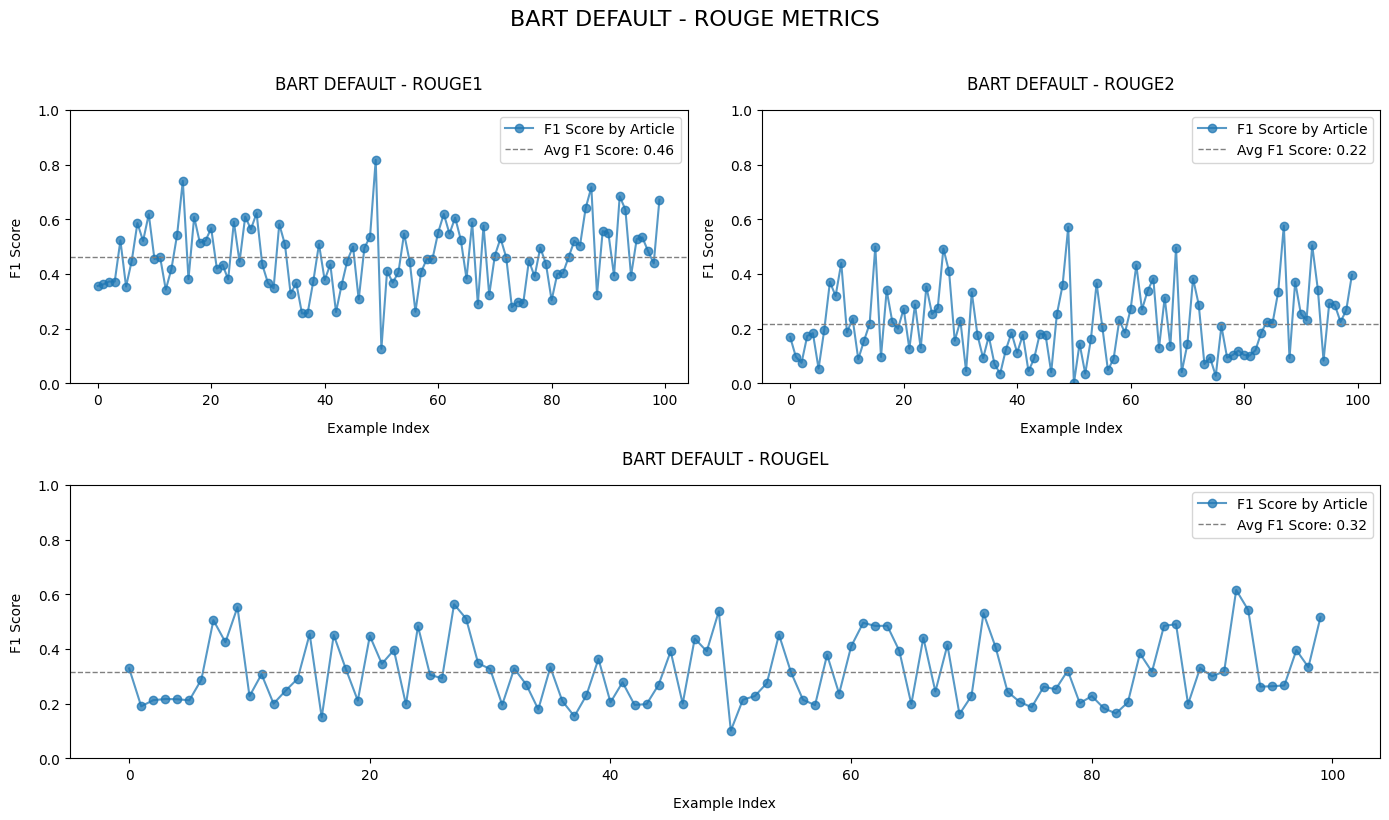

Evaluating: BART_BEAM_LIGHT...

Generating summaries for 100 articles...

Completed in 00:11:18.79


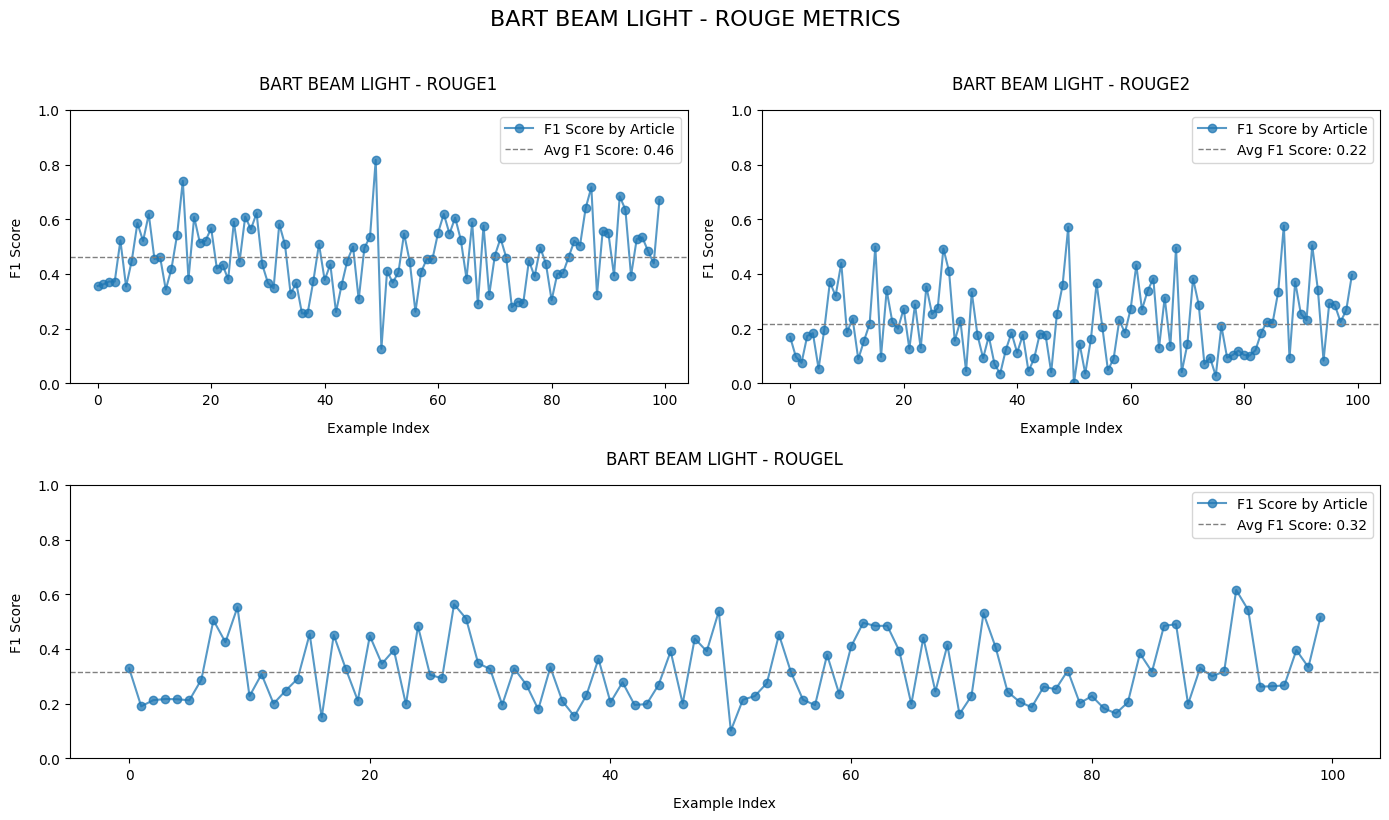

Evaluating: BART_BEAM...

Generating summaries for 100 articles...

Completed in 00:11:29.20


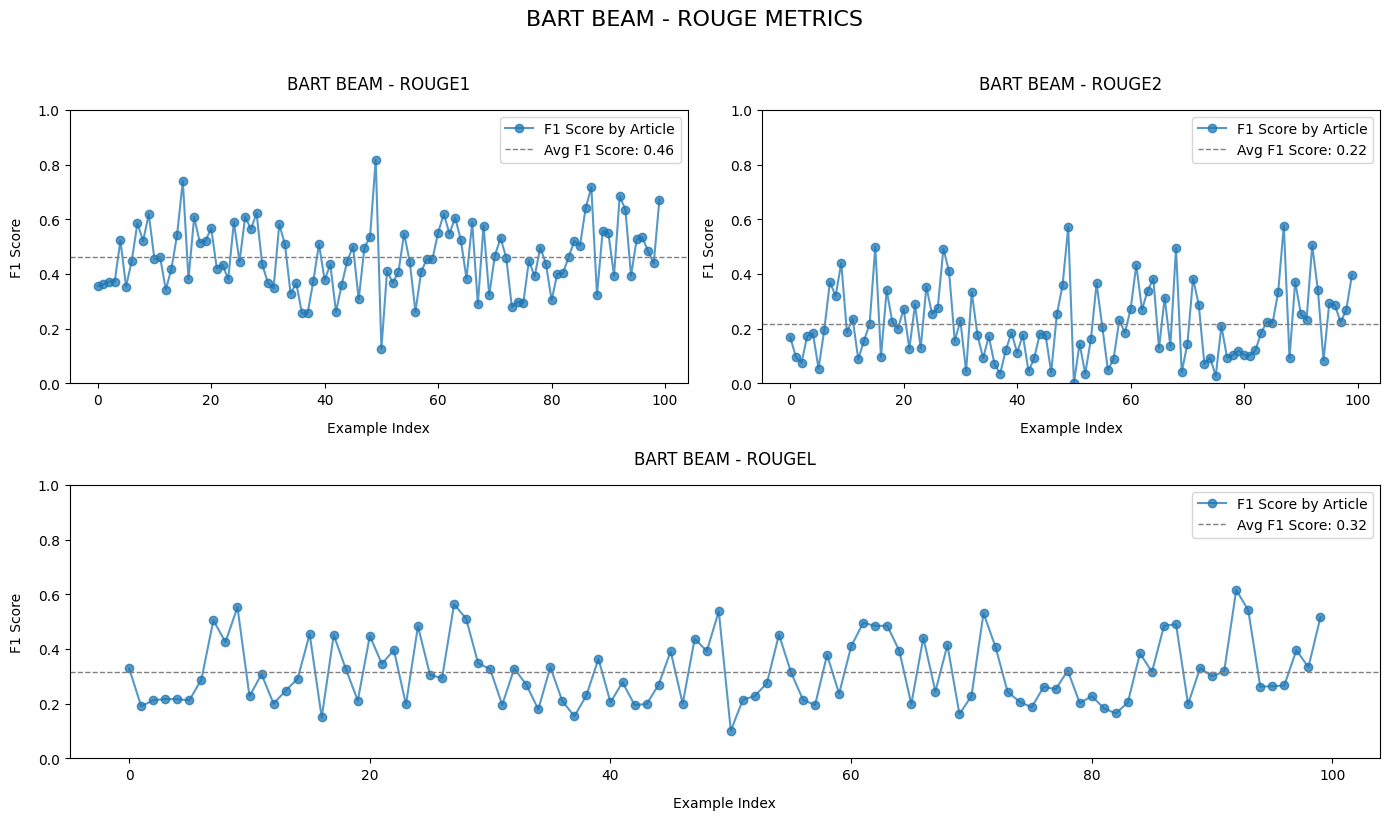

Evaluating: BART_SHORT...

Generating summaries for 100 articles...

Completed in 00:11:23.39


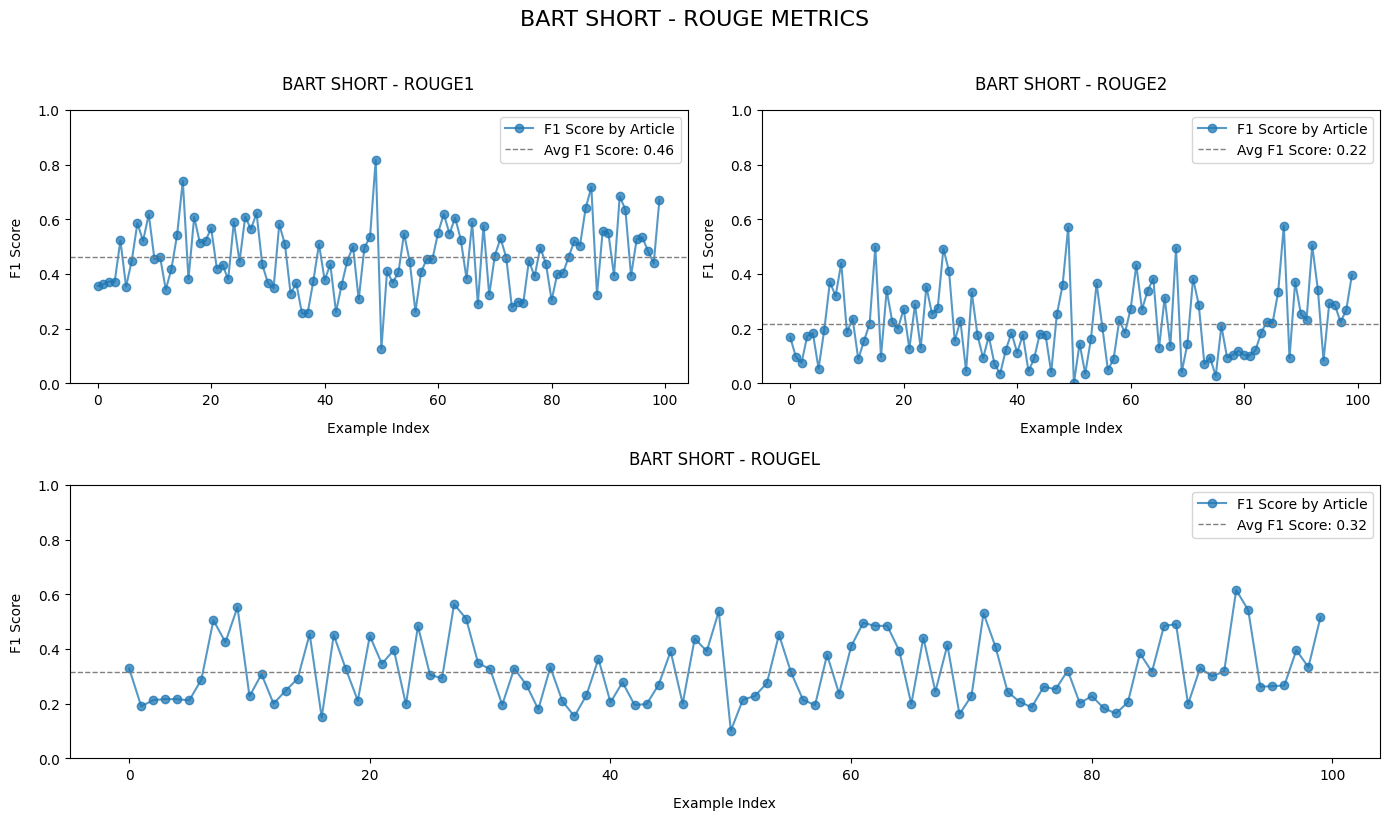

Evaluating: BART_SAMPLE_BASIC...

Generating summaries for 100 articles...

Completed in 00:12:23.47


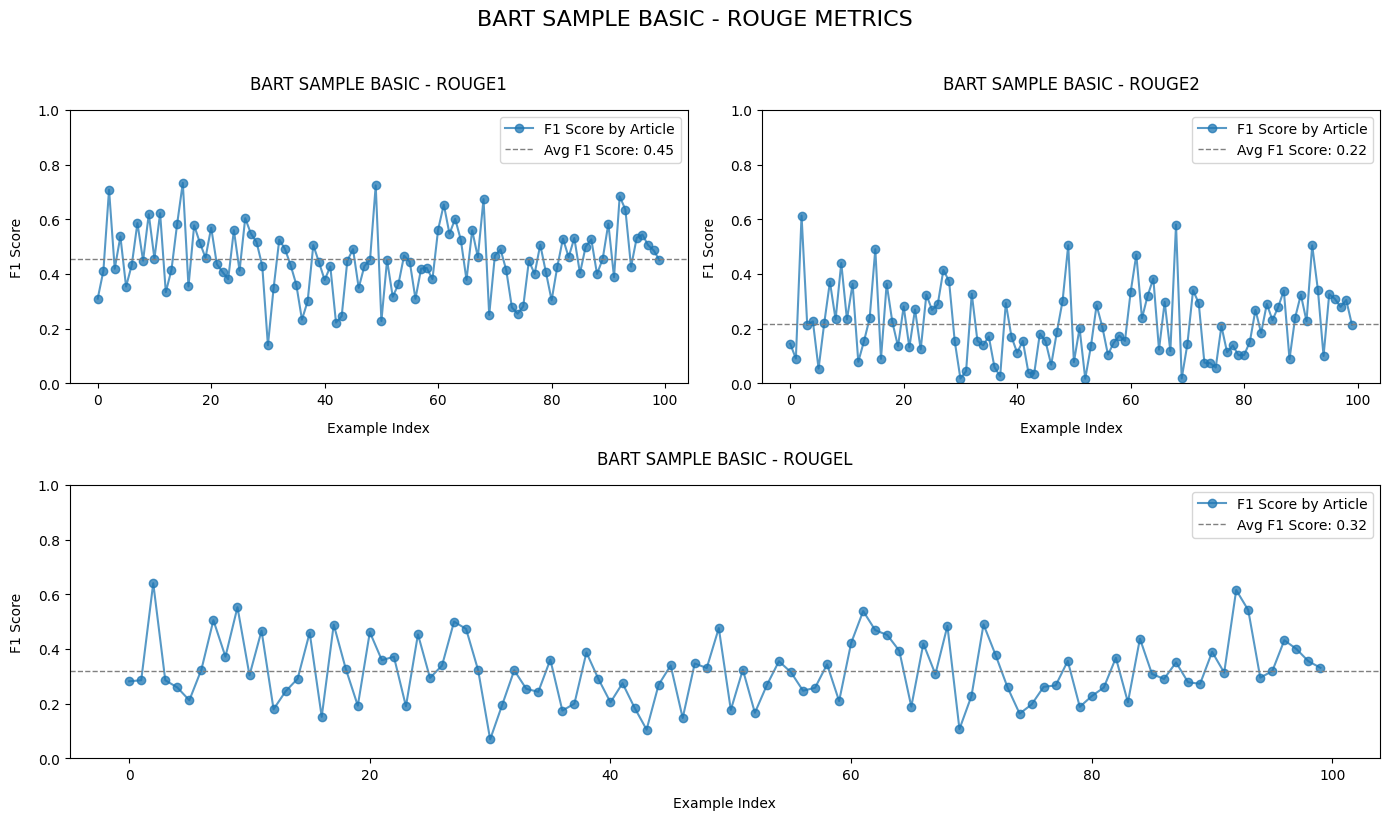

Evaluating: BART_SAMPLE_TEMP...

Generating summaries for 100 articles...

Completed in 00:12:9.91


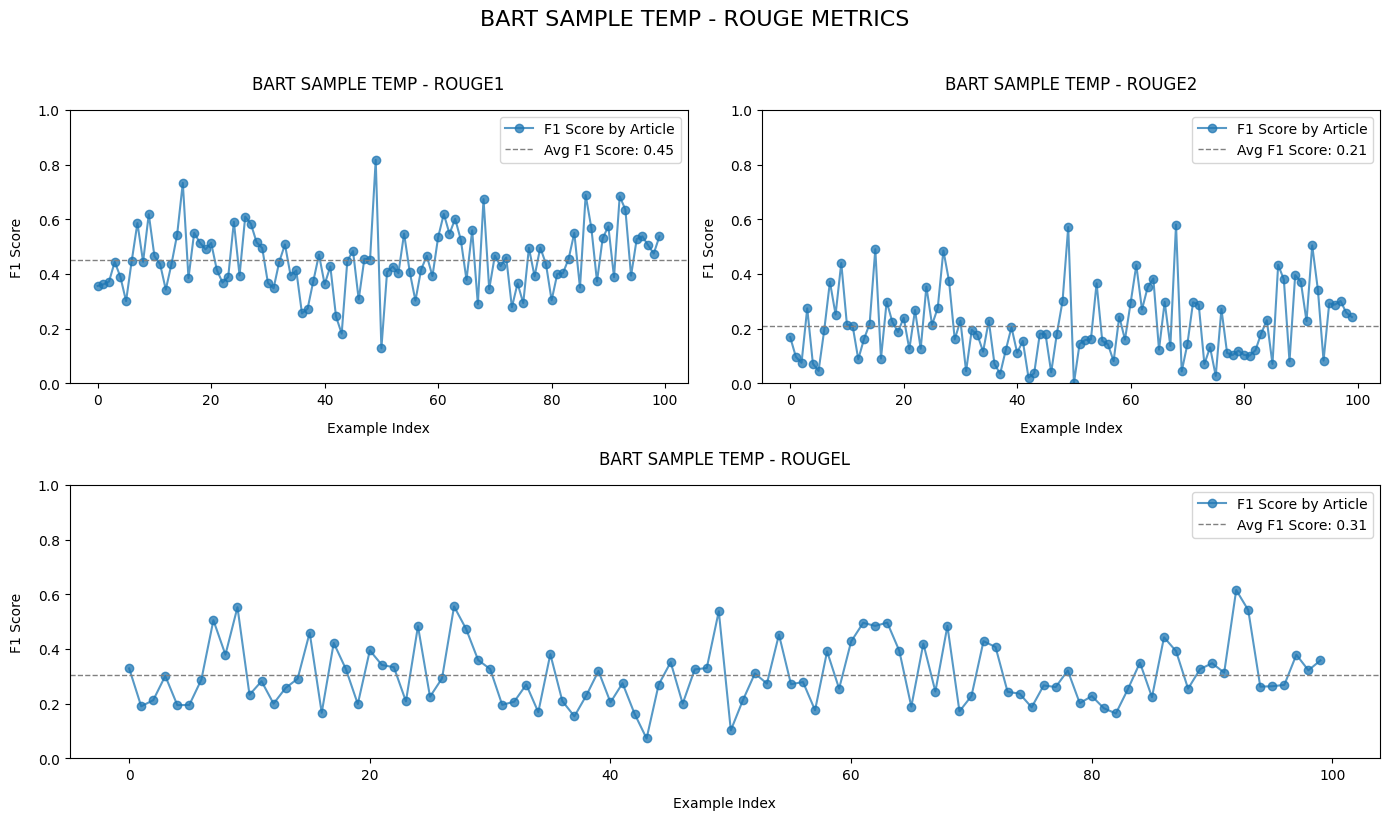

Evaluating: BART_SAMPLE_TOPK...

Generating summaries for 100 articles...

Completed in 00:12:17.17


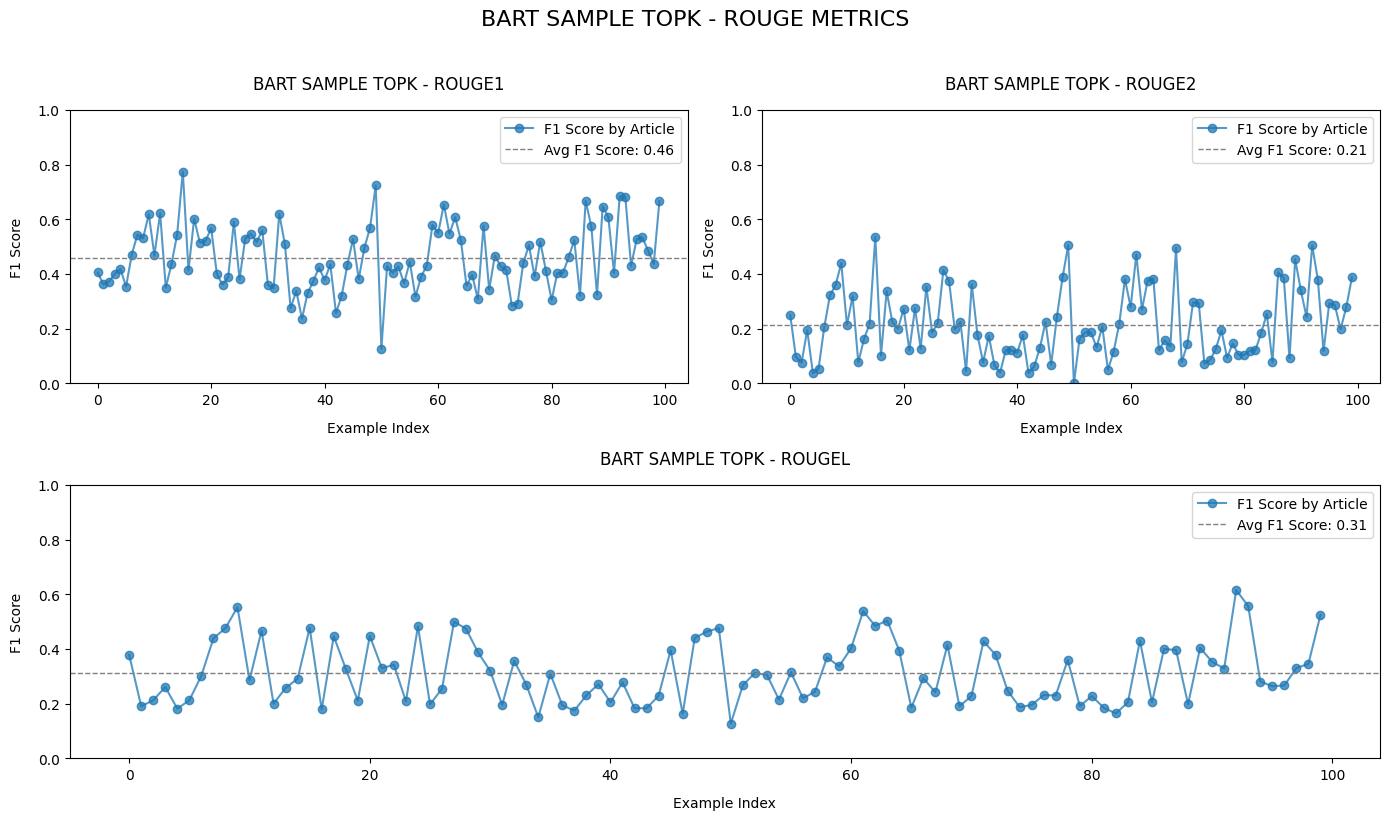

Evaluating: BART_SAMPLE_TOPP...

Generating summaries for 100 articles...

Completed in 00:12:38.06


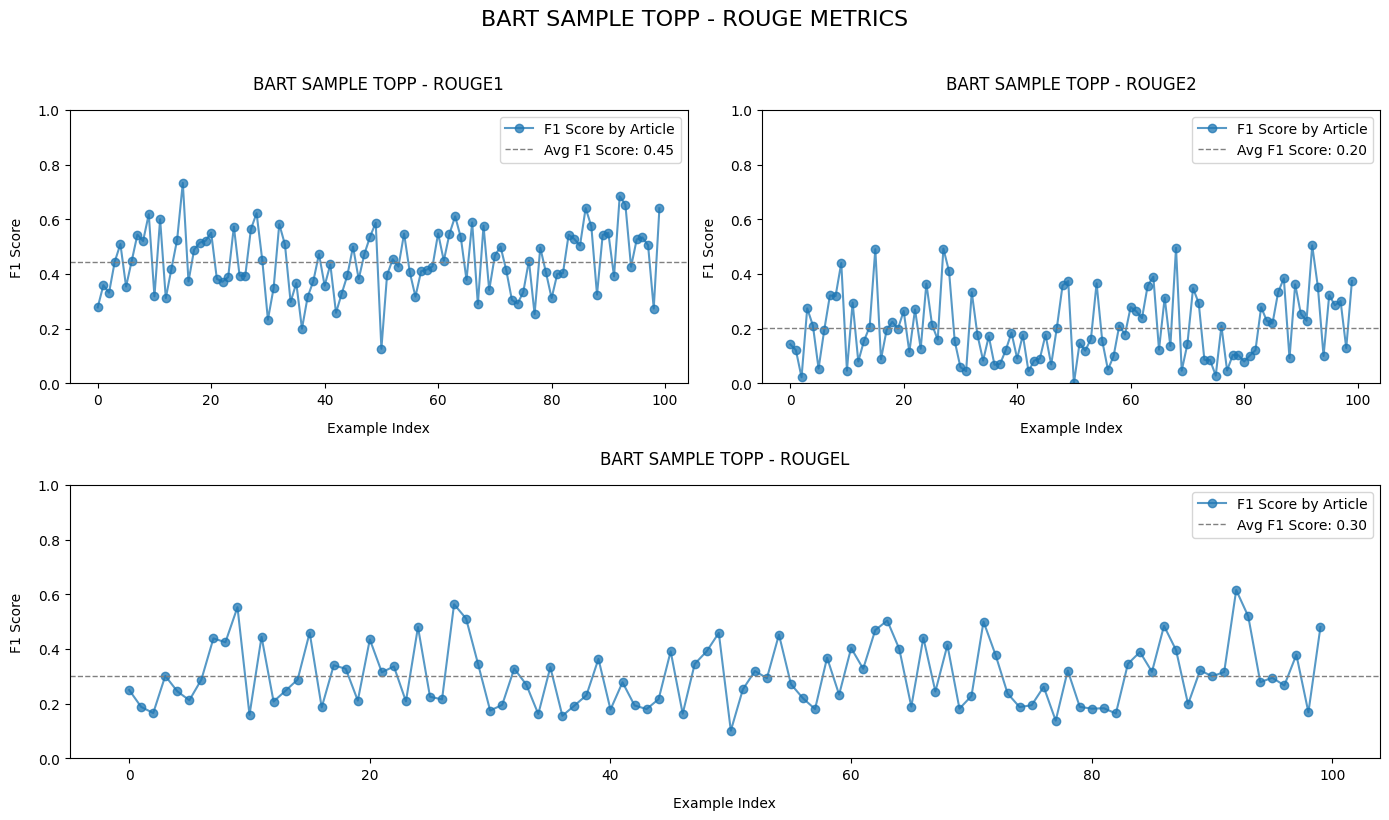

Evaluating: BART_SAMPLE_TOPKP...

Generating summaries for 100 articles...

Completed in 00:12:1.86


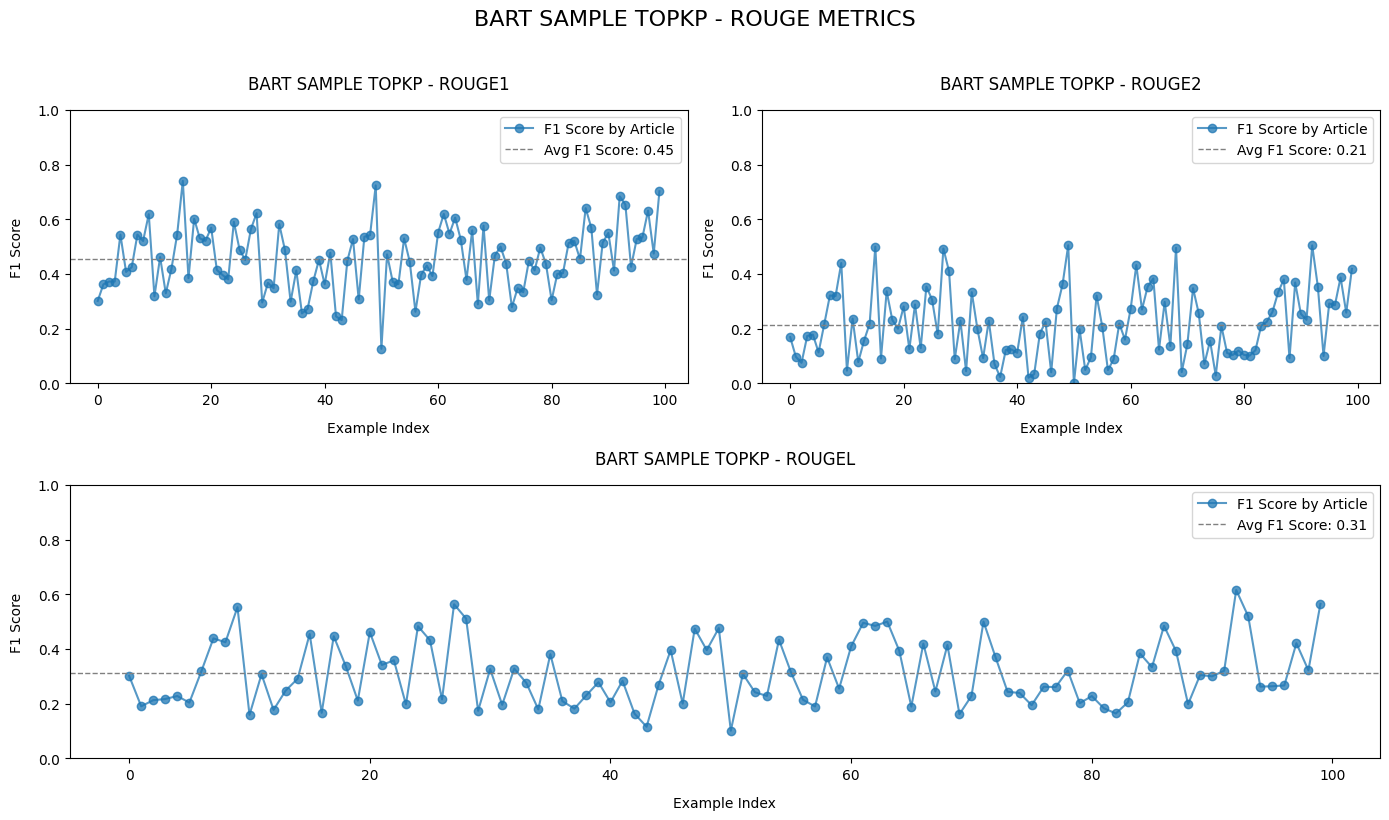

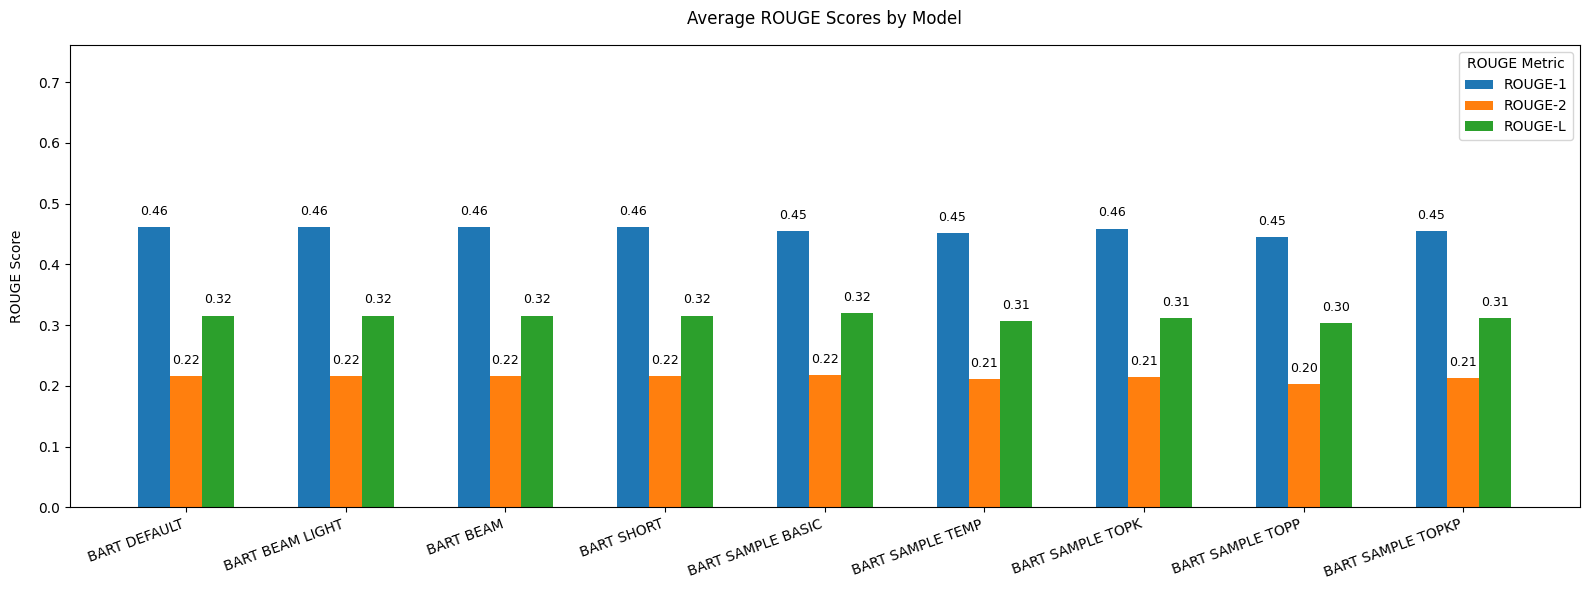

In [18]:
ablation_scores = sum_eval(articles, ablation_configs)
df_ablation = pd.DataFrame(ablation_scores).T.sort_values(by='rougeL', ascending=False)
plot_avg_rouge(ablation_scores, save_path=os.path.join(results_dir, 'ablation_avg_rouge_scores'))

#### Manual Evaluation



In [19]:
# Select 3 random articles
NUM_RANDOM_SAMPLES = 3
manual_ablation_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

##### BART DEFAULT

In [20]:
bart_default_summarizer = ablation_configs['bart_default']
bart_default_summaries = bart_default_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:14.56


In [21]:
# Evaluate Bart Default
bart_default_evaluator = ExtrinsicEvaluator(bart_default_summaries)
bart_default_evaluator.evaluate('BART DEFAULT')
bart_default_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_default_evaluator.submit_scores(bart_default_id_to_score)

Manually evaluating BART DEFAULT...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causing su

##### BART BEAM LIGHT

In [22]:
# Generate Summaries
bart_beam_light_summarizer = ablation_configs['bart_beam_light']
bart_beam_light_summaries = bart_beam_light_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:14.35


In [23]:
# Evaluate Bart Light Beam
bart_beam_light_evaluator = ExtrinsicEvaluator(bart_beam_light_summaries)
bart_beam_light_evaluator.evaluate('BART LIGHT BEAM')
bart_beam_light_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_beam_light_evaluator.submit_scores(bart_beam_light_id_to_score)

Manually evaluating BART LIGHT BEAM...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causing

##### BART BEAM

In [24]:
# Generate Summaries
bart_beam_summarizer = ablation_configs['bart_beam']
bart_beam_summaries = bart_beam_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:14.96


In [25]:
# Evaluate Bart Beam
bart_beam_evaluator = ExtrinsicEvaluator(bart_beam_summaries)
bart_beam_evaluator.evaluate('BART BEAM')
bart_beam_id_to_score = {  # Summaries identical to bart beam light
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,  # Identical to bart beam light
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to bart beam light
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to bart beam light
} 
bart_beam_evaluator.submit_scores(bart_beam_id_to_score)

Manually evaluating BART BEAM...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causing sunbu

##### BART SHORT

In [26]:
# Generate Summaries
bart_short_summarizer = ablation_configs['bart_short']
bart_short_summaries = bart_short_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:14.39


In [27]:
# Evaluate Bart Short
bart_short_evaluator = ExtrinsicEvaluator(bart_short_summaries)
bart_short_evaluator.evaluate('BART SHORT')
bart_short_id_to_score = {  # Identical summaries to bart beam light and bart beam
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_short_evaluator.submit_scores(bart_short_id_to_score)

Manually evaluating BART SHORT...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causing sunb

##### BART SAMPLE BASIC

In [28]:
# Generate Summaries
bart_sample_basic_summarizer = ablation_configs['bart_sample_basic']
bart_sample_basic_summaries = bart_sample_basic_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:15.44


In [29]:
# Evaluate Bart Sample Basic
# These were almost the same as previous ones, but were slightly shorter and lost some important details

bart_sample_basic_evaluator = ExtrinsicEvaluator(bart_sample_basic_summaries)
bart_sample_basic_evaluator.evaluate('BART SAMPLE BASIC')
bart_sample_basic_id_to_score = {  # First different summaries
    "82d9d60e0360159b6767e0921de88360a93da0f5": 4,  # Almost better than highlights. Doesnt mention loss to Manchester United
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 4,  # Almost identical to previous, but doesn't mention Penny was cleared
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4   # Doesnt mention talks with Aston Villa
}
bart_sample_basic_evaluator.submit_scores(bart_sample_basic_id_to_score)

Manually evaluating BART SAMPLE BASIC...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causi

##### BART SAMPLE TEMP

In [30]:
# Generate Summaries
bart_sample_temp_summarizer = ablation_configs['bart_sample_temp']
bart_sample_temp_summaries = bart_sample_temp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:15.70


In [31]:
# Evaluate Bart Sample Basic
bart_sample_temp_evaluator = ExtrinsicEvaluator(bart_sample_temp_summaries)
bart_sample_temp_evaluator.evaluate('BART SAMPLE TEMP')
bart_sample_temp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  # Doesn't mention loss to Manchester United, doesnt finish last thought
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 3,  # Missing details on being cleared. Doesnt finish thought
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4  # Just doesnt mention Aston Villa talks
}
bart_sample_temp_evaluator.submit_scores(bart_sample_temp_id_to_score)

# Not as good as other models. Doesn't always finish sentences. Some details provided are not important

Manually evaluating BART SAMPLE TEMP...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causin

##### BART SAMPLE TOPK

In [32]:
# Generate Summaries
bart_sample_topk_summarizer = ablation_configs['bart_sample_topk']
bart_sample_topk_summaries = bart_sample_topk_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:16.21


In [33]:
# Evaluate Bart Sample TopK
bart_sample_topk_evaluator = ExtrinsicEvaluator(bart_sample_topk_summaries)
bart_sample_topk_evaluator.evaluate('BART SAMPLE TOPK')
bart_sample_topk_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  # Doesn't mention 4-2 loss to Manchester United 
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to bart light beam and bart beam
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to bart light beam and bart beam
}
bart_sample_topk_evaluator.submit_scores(bart_sample_topk_id_to_score)

# Almost as good as other models with some details being lost and a sentence not being completed

Manually evaluating BART SAMPLE TOPK...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causin

##### BART SAMPLE TOPP

In [34]:
# Generate Summaries
bart_sample_topp_summarizer = ablation_configs['bart_sample_topp']
bart_sample_topp_summaries = bart_sample_topp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:14.29


In [35]:
# Evaluate Bart Sample TopP
bart_sample_topp_evaluator = ExtrinsicEvaluator(bart_sample_topp_summaries)
bart_sample_topp_evaluator.evaluate('BART SAMPLE TOPP')
bart_sample_topp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  # Doesn't mention 4-2 loss to Manchester United
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to previous summaries
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4  # Doesn't mention some enquiries
}
bart_sample_topp_evaluator.submit_scores(bart_sample_topp_id_to_score)

# Strong performance with some smaller details missing

Manually evaluating BART SAMPLE TOPP...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causin

##### BART SAMPLE TOPKP

In [36]:
# Generate Summaries
bart_sample_topkp_summarizer = ablation_configs['bart_sample_topkp']
bart_sample_topkp_summaries = bart_sample_topkp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:15.59


In [37]:
# Evaluate Bart Sample Basic
bart_sample_topkp_evaluator = ExtrinsicEvaluator(bart_sample_topkp_summaries)
bart_sample_topkp_evaluator.evaluate('BART SAMPLE TOPKP')
bart_sample_topkp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,  # This is the best one so far, mentioning that City lost on a Sunday
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to other models
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to other models
}
bart_sample_topkp_evaluator.submit_scores(bart_sample_topkp_id_to_score)

# Performed slightly better than the best models

Manually evaluating BART SAMPLE TOPKP...
ID: e1dc06aa877f2285b915edd80419aaab216add47
Article:
Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows. Decades of cheap package holidays mean that thousands of retired people every year are paying with their health for sunburn they experienced in their youth. According to Cancer Research UK, men aged 65 and over are around ten times more likely to be diagnosed with malignant melanoma than those of their parents’ generation. Scroll down for video . Pensioners are seven times more likely to develop serious skin cancer today than they were 40 years ago, research shows . And older women are about five times more likely to develop this disease than someone of the same age were in the mid-1970s. Around 5,700 pensioners are now diagnosed with melanoma each year in the UK compared with just 600 a year four decades ago. Many of the patients being diagnosed today suffered cancer-causi

## Manual Evaluation Results

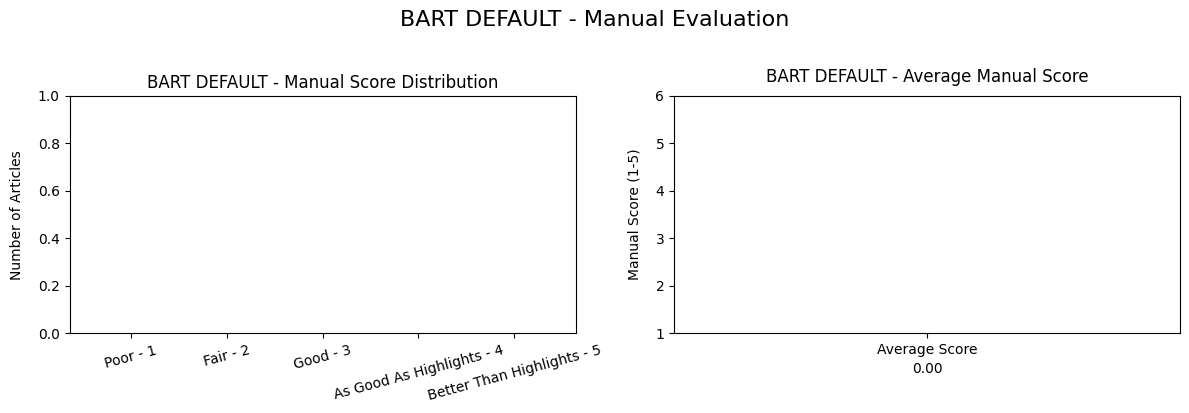

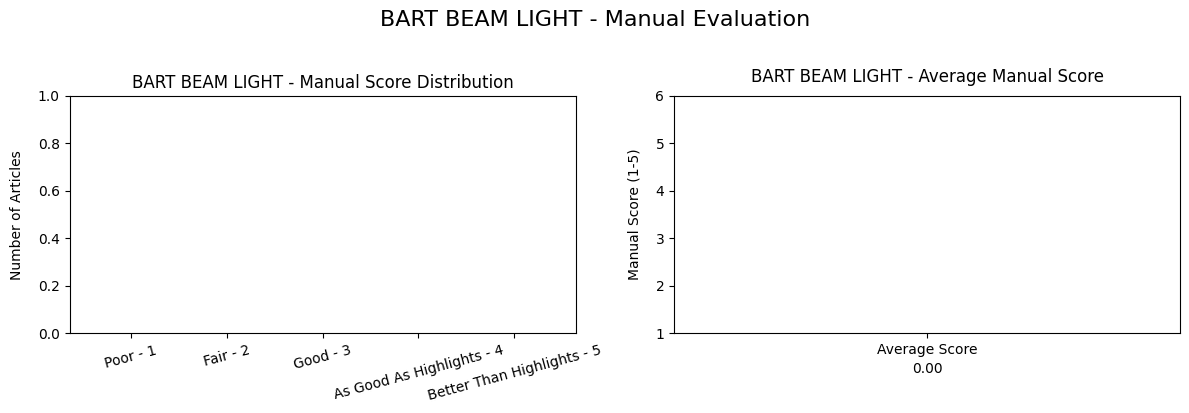

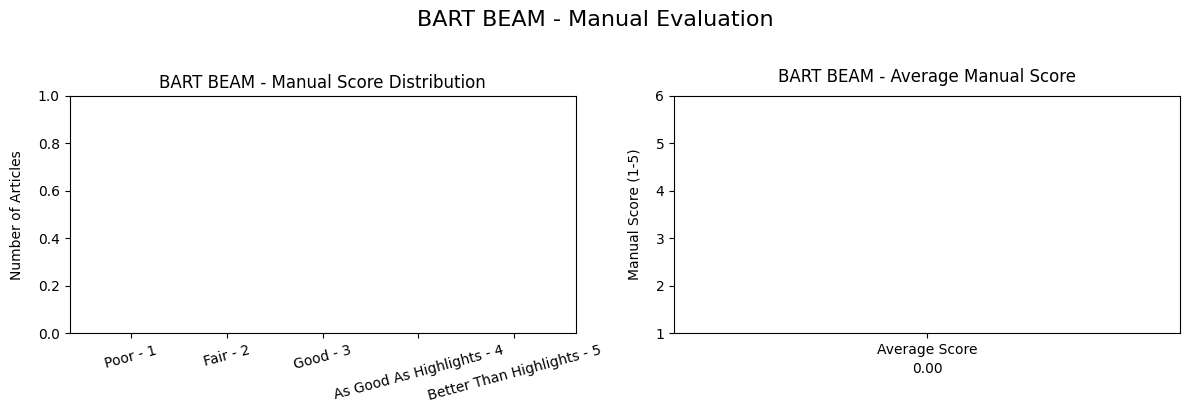

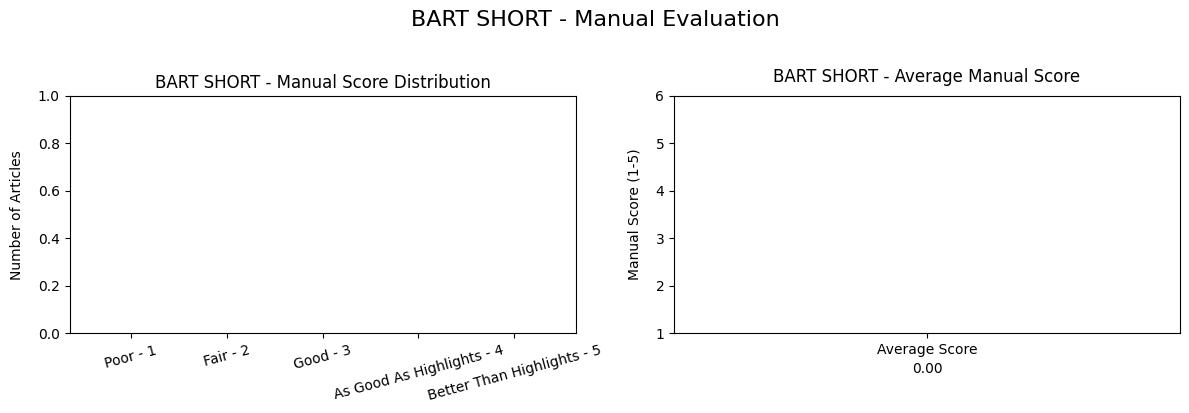

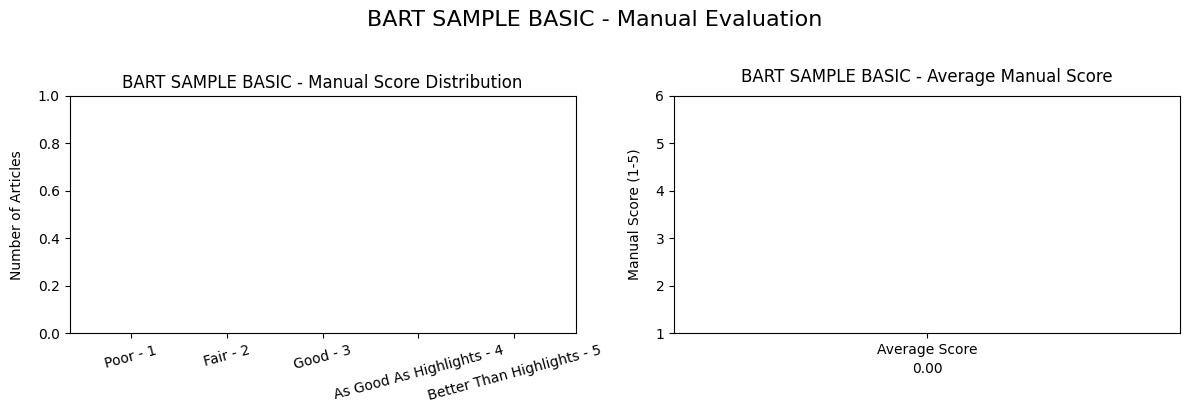

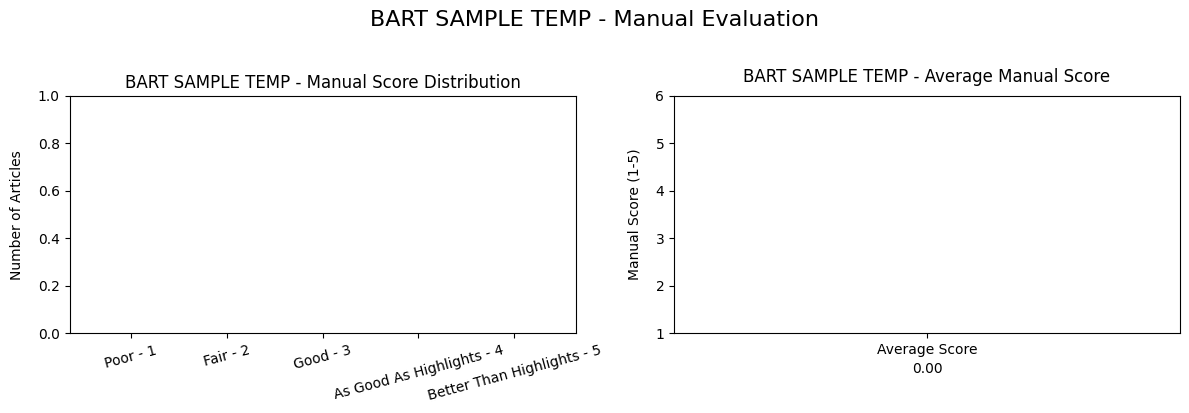

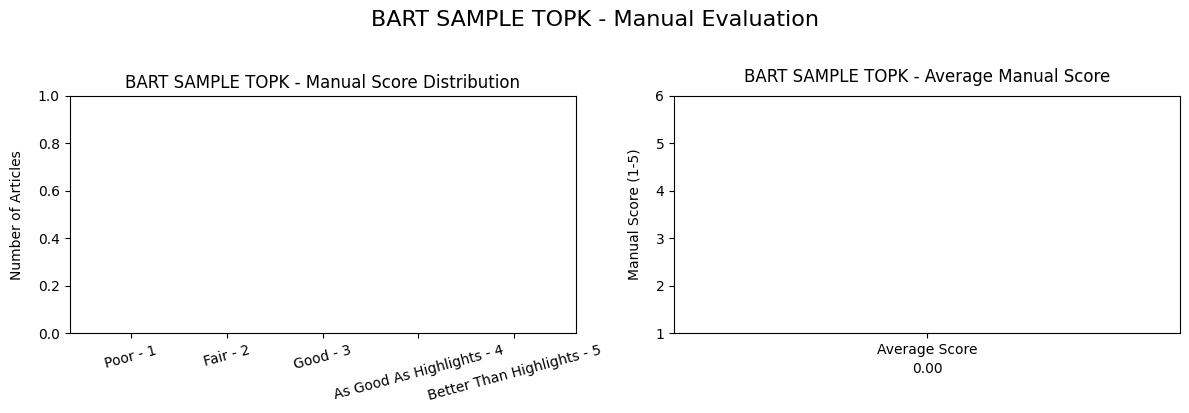

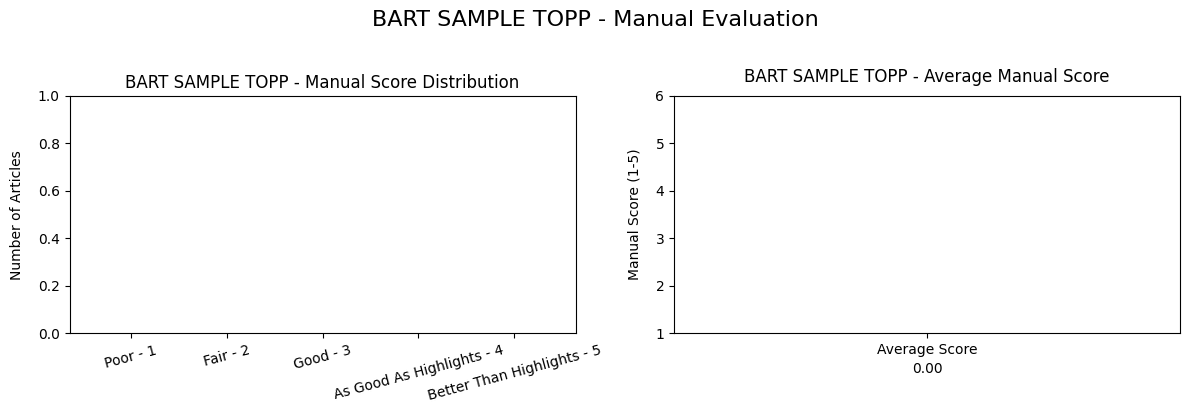

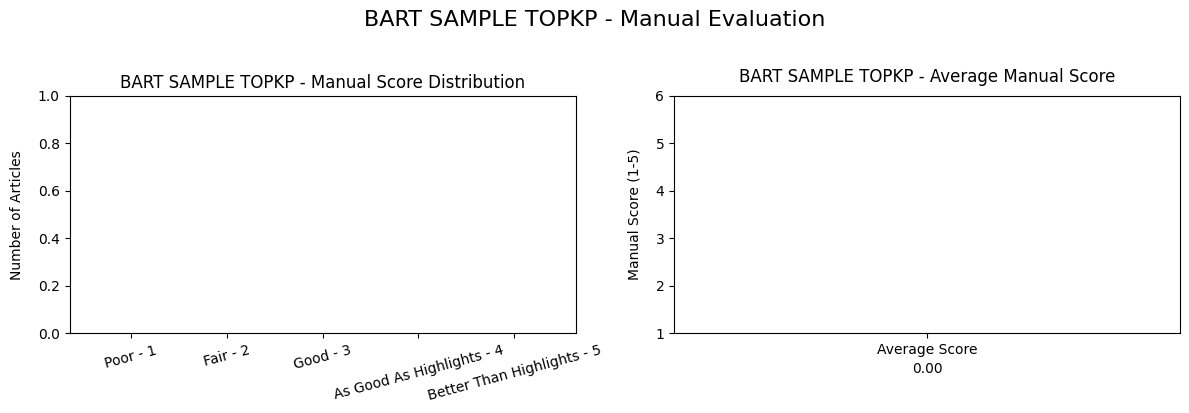

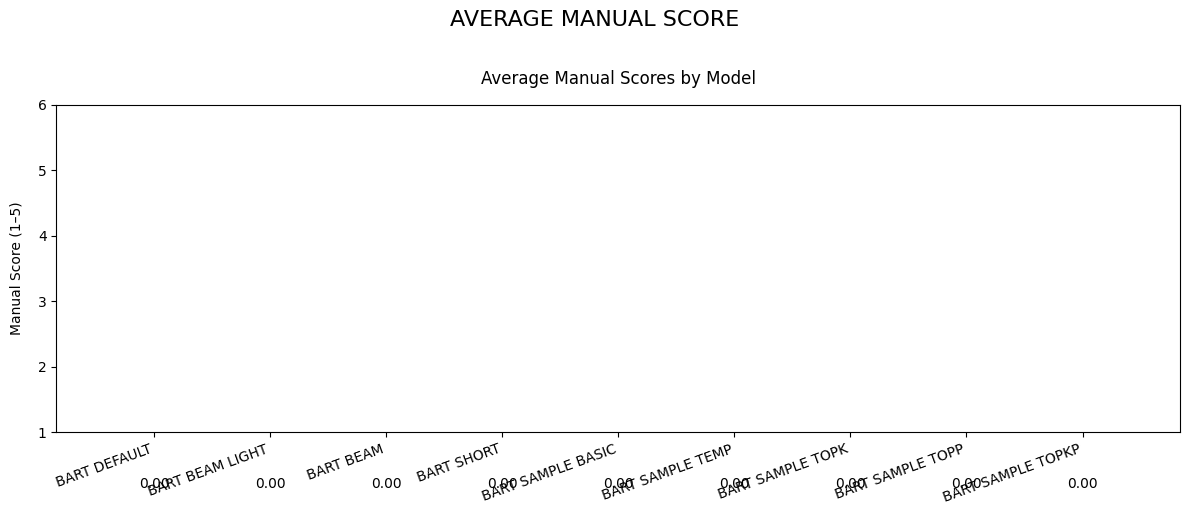

In [38]:
# Plot ablation models
bart_default_evaluator.plot('BART DEFAULT', save_path=os.path.join(results_dir, 'bart_default'))
bart_beam_light_evaluator.plot('BART BEAM LIGHT', save_path=os.path.join(results_dir, 'bart_beam_light'))
bart_beam_evaluator.plot('BART BEAM', save_path=os.path.join(results_dir, 'bart_beam'))
bart_short_evaluator.plot('BART SHORT', save_path=os.path.join(results_dir, 'bart_short'))
bart_sample_basic_evaluator.plot('BART SAMPLE BASIC', save_path=os.path.join(results_dir, 'bart_sample_basic'))
bart_sample_temp_evaluator.plot('BART SAMPLE TEMP', save_path=os.path.join(results_dir, 'bart_sample_temp'))
bart_sample_topk_evaluator.plot('BART SAMPLE TOPK', save_path=os.path.join(results_dir, 'bart_sample_topk'))
bart_sample_topp_evaluator.plot('BART SAMPLE TOPP', save_path=os.path.join(results_dir, 'bart_sample_topp'))
bart_sample_topkp_evaluator.plot('BART SAMPLE TOPKP', save_path=os.path.join(results_dir, 'bart_sample_topkp'))

ablation_avg_manual_scores = {
    'bart_default': bart_default_evaluator.avg_score,
    'bart_beam_light': bart_beam_light_evaluator.avg_score,
    'bart_beam': bart_beam_evaluator.avg_score,
    'bart_short': bart_short_evaluator.avg_score,
    'bart_sample_basic': bart_sample_basic_evaluator.avg_score,
    'bart_sample_temp': bart_sample_temp_evaluator.avg_score,
    'bart_sample_topk': bart_sample_topk_evaluator.avg_score,
    'bart_sample_topp': bart_sample_topp_evaluator.avg_score,
    'bart_sample_topkp': bart_sample_topkp_evaluator.avg_score,
    
}

plot_avg_manual_score(ablation_avg_manual_scores, save_path=os.path.join(results_dir, 'ablation_avg_manual_scores'))